In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import read
import librosa
import librosa.display

In [2]:
os.chdir("/")
os.mkdir("MLSP") 
os.chdir("/MLSP")

In [3]:
os.getcwd()

'/MLSP'

In [4]:
clean, sr = librosa.load("clean.wav", sr=16000)
noise, sr = librosa.load("noisy.wav", sr=16000)

In [5]:
time_length = clean.shape[0]/sr 
time_length

3.125

In [6]:
N=int(16000*0.025)
hop=int(0.01*16000)
window = 0.025
hop_time = 0.010
overlap_time = 0.015
time_lenght = 3.125                                     # from above
# formula for calculating the number of feature
no_features = (time_length-overlap_time)/hop_time
no_features                                             # so no. of features = 311

311.0

In [7]:
# making data matrix
def mat(X):
   feature_mat=np.zeros((128,311),dtype='complex_')
   n=0
   N=int(16000*0.025)
   hop=int(0.01*16000)
   for i in range(311):
      # first we will take a segment 
      y_segment = X[n:n+N]
      # then ww will apply hamming window over it
      y_h = y_segment * np.hamming(N)
      # then we will calculate fft of the segment
      y_f = np.fft.fft(y_h,256)
      # as it is symmetric(magnitude) we will take first 128
      y_f1 = y_f[:128]
      # and add as column to our feature matrix
      feature_mat[:,i] = y_f1
      # now we jump hop=160 points, again form a segment
      n = n + hop

   # now we will calculate the absolute value 
   feature_ab=np.abs(feature_mat)
   # now we will compute log values
   feature_log=np.log(feature_ab) 

   return(feature_log)

In [8]:
# Whitening
def ComputeWhitening(X):
  row=X.shape[0]
  column=X.shape[1]
  # computing mean along all features i.e along columns
  X_mean=np.mean(X,1)
  X_mean=X_mean.reshape(row,1)
  # substracting mean from original matrix
  X1=X-X_mean
  # calculating the covariance
  cov=(X1.dot(X1.T))/(column-1)
  # computing the eigen vector and eigen value
  eig_val,eig_vec=np.linalg.eig(cov)
  # sorting the eigen vector and eigen eigen in decreasing eigen value
  decreasing_order_index=np.argsort(eig_val)[::-1]
  eig_val=eig_val[decreasing_order_index]
  eig_vec = eig_vec[:,decreasing_order_index]
  # eigen value manipulation for whitening
  eig_val1=1/np.sqrt(eig_val)
  # eigen value matrix
  eigen_val_mat = np.diag(eig_val1)
  # eigne vector matrix
  eigen_vec_mat = eig_vec
  # multiplication of eigen value matrix and transpose of eigen vector matrix
  tt=eigen_val_mat.dot(eigen_vec_mat.T)
  return tt


In [9]:
#apply whitening
# here X is the matrix on which the transformation is to be applied, and the Y is matrix from which
# tranformation matrix is taken
def applywhitening(X,Y):
  row=X.shape[0]
  X_mean= np.mean(X,1)        
  X_mean=X_mean.reshape(row,1)
  X=X-X_mean
  tran=Y.dot(X)
  return tran

In [10]:
# mean of non diagonal values
def mean_non_diag_entry(X):
  row=X.shape[0]
  sum_of_all=0
  for i in range(row):
    for j in range(row):
      if (i!=j):
        sum_of_all=sum_of_all+np.abs(X[i][j])
  mean=sum_of_all/((128**2)-128)
  return mean

In [11]:
# spectogram
def plot_spectrogram(X, sr, hop,title):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(X,sr=sr,hop_length=hop,x_axis="time")
    plt.colorbar(format="%+2.f")   
    plt.title(title)

Spectogram of Clean
Spectogram of Noise
The average of non diagonal entry for whitened nosie (whitening transformation computed from clean) is  0.15264469579042253
The average of non diagonal entry for whitened clean (whitening transformation computed from noisy) is  0.12236253369723582
The average of non diagonal entry for whitened clean (whitening transformation computed from clean) is  5.4801273840114325e-15
The average of non diagonal entry for whitened noise (whitening transformation computed from nosie) is  1.1485058777539844e-15


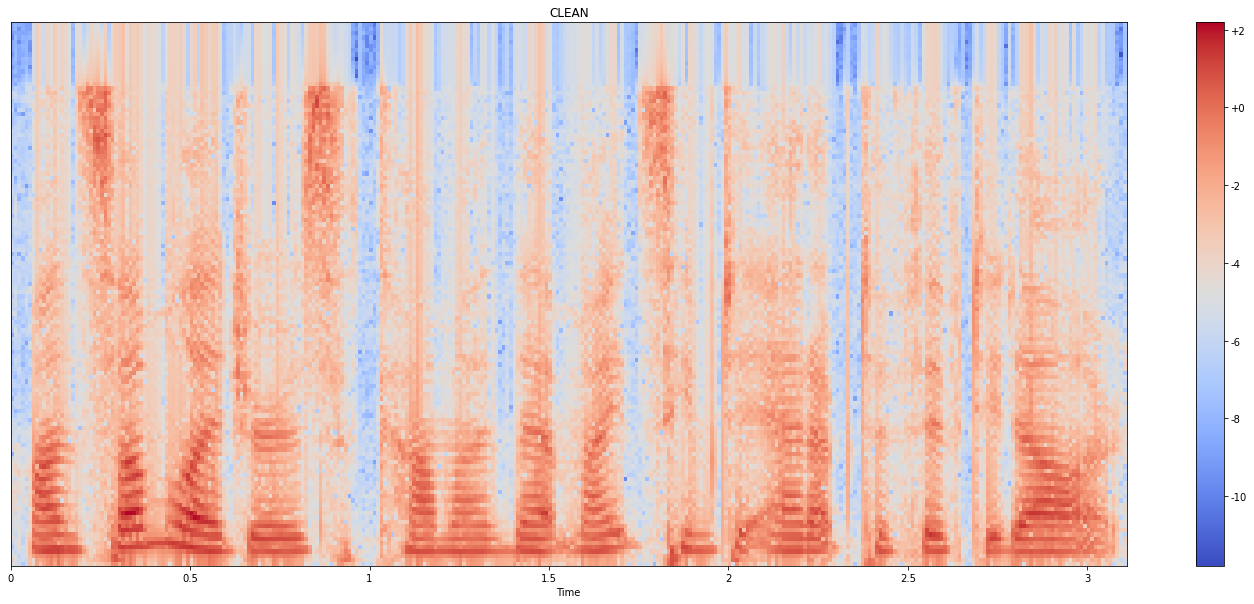

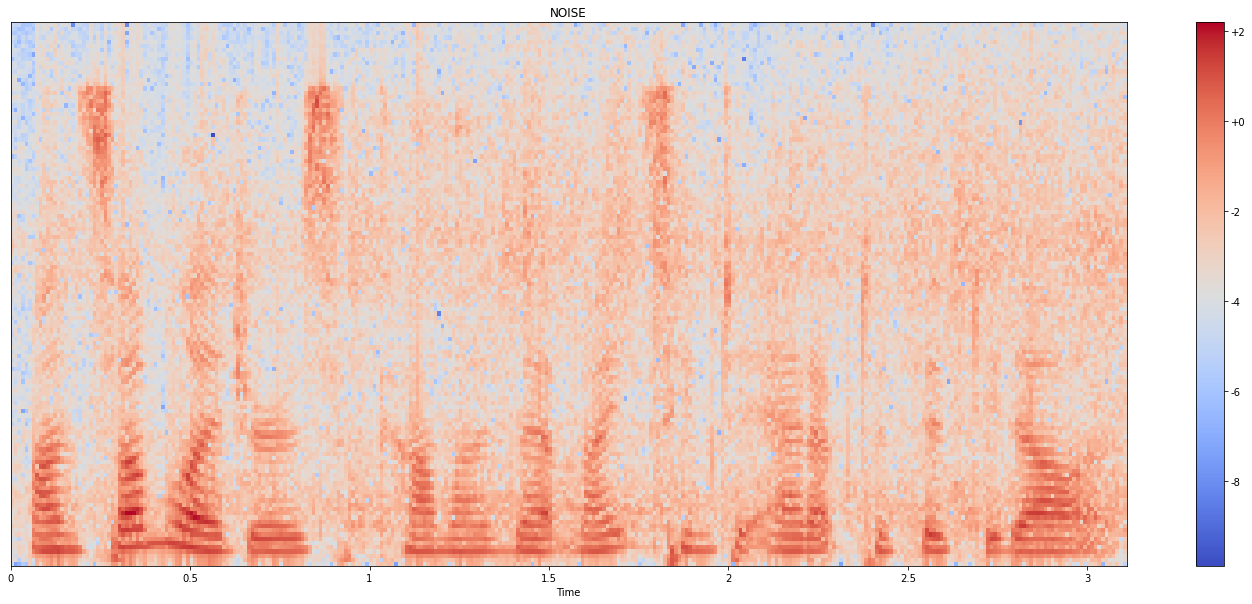

In [12]:
# calling
clean_after_log = mat(clean)
noise_after_log = mat(noise)
 
 
print("Spectogram of Clean")
plot_spectrogram(clean_after_log,sr,hop,'CLEAN')
print("Spectogram of Noise")
plot_spectrogram(noise_after_log,sr,hop,'NOISE')

 # now compute whitening transform from "clean" and "noise", i.e. eigen vector matrix and eigen value matrix
whitening_computed_from_clean = ComputeWhitening(clean_after_log)
whitening_computed_from_noise = ComputeWhitening(noise_after_log)

 # now apply whitening trasform(computed from clean) to noisy 
whitening_on_noise_by_clean = applywhitening(noise_after_log,whitening_computed_from_clean)
 # now apply whitening trasform(computed from clean) to clean 
whitening_on_clean_by_clean = applywhitening(clean_after_log,whitening_computed_from_clean)
 # now apply whitening trasform(computed from clean) to noisy 
whitening_on_clean_by_noise = applywhitening(clean_after_log,whitening_computed_from_noise)
# now apply whitening trasform(computed from clean) to noisy 
whitening_on_noise_by_noise = applywhitening(noise_after_log,whitening_computed_from_noise)


 # covarinace after applying whitening transform
cov_noise_by_clean = np.cov(whitening_on_noise_by_clean)
cov_clean_by_clean = np.cov(whitening_on_clean_by_clean)
cov_clean_by_noise = np.cov(whitening_on_clean_by_noise)
cov_noise_by_noise = np.cov(whitening_on_noise_by_noise)


 # mean of absolute non diagonal entry
avg_noise_by_clean = mean_non_diag_entry(cov_noise_by_clean)
avg_clean_by_clean = mean_non_diag_entry(cov_clean_by_clean)
avg_clean_by_noise = mean_non_diag_entry(cov_clean_by_noise)
avg_noise_by_noise = mean_non_diag_entry(cov_noise_by_noise)


 # print the values
print("The average of non diagonal entry for whitened nosie (whitening transformation computed from clean) is ",avg_noise_by_clean) 
print("The average of non diagonal entry for whitened clean (whitening transformation computed from noisy) is ",avg_clean_by_noise)
print("The average of non diagonal entry for whitened clean (whitening transformation computed from clean) is ",avg_clean_by_clean) 
print("The average of non diagonal entry for whitened noise (whitening transformation computed from nosie) is ",avg_noise_by_noise)



